# Analysis with Ensemble Methods

In this botebook, I will anlyze the data using the Decision Trees.

## Load Libraries

In [194]:
# Import base libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from datetime import datetime

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

## Load Data

There are five data files: 
    * data1, 1year.arff 
    * data2, 2year.arff 
    * data3, 3year.arff
    * data4, 4year.arff
    * data5, 5year.arff

Initially, I will explore the models on data3. After determing the final model design, I will apply it on other datasets and compare te results.

I will use previously cleaned data, where missing values are handled.


In [180]:
# Load Clean Data (no missing values, no outliers)

df3 = pd.read_csv('data/data3_noMiss.csv')
df3.head()

,Attr1,Attr2,Attr3,Attr4,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,...,Attr50,Attr51,Attr55,Attr56,Attr57,Attr58,Attr59,Attr62,Attr63,class
0,0.174190,0.41299,0.14371,1.3480,0.60383,0.219460,1.1225,1.1961,0.46359,0.219460,...,1.3480,0.41299,127280.0,0.163960,0.375740,0.83604,0.000007,84.291,4.3303,0
1,0.146240,0.46038,0.28230,1.6294,0.00000,0.171850,1.1721,1.6018,0.53962,0.175790,...,1.5874,0.44849,3387.8,0.027516,0.271000,0.90108,0.000000,102.190,3.5716,0
2,0.000595,0.22612,0.48839,3.1599,0.19114,0.004572,2.9881,1.0077,0.67566,0.004572,...,3.1599,0.22612,20453.0,0.007639,0.000881,0.99236,0.000000,64.846,5.6287,0
3,0.024526,0.43236,0.27546,1.7833,0.56944,0.024526,1.3057,1.0509,0.56453,0.024526,...,1.4504,0.35164,5012.6,0.048398,0.043445,0.95160,0.142980,98.783,3.6950,0
4,0.188290,0.41504,0.34231,1.9279,0.00000,0.233580,1.4094,1.3393,0.58496,0.238810,...,1.7136,0.36891,13730.0,0.176480,0.321880,0.82635,0.073039,100.540,3.6303,0


In [181]:
df3.shape

(10445, 49)

## Pre-process

In [182]:
# Assign target and predictor
y = df3['class']
X = df3.drop('class', axis=1)

In [183]:
# Sepearate data into train and test splist

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (8356, 48)
y_train shape =  (8356,)
X_test shape =  (2089, 48)
y_test shape =  (2089,)


In [184]:
# Scale/Normalize the predictor variables

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to Dataframe
#X_train = pd.DataFrame(X_train, columns=X.columns)
#X_test = pd.DataFrame(X_test, columns=X.columns)
#X_train.head()

### Class imbalance and Resampling

In [185]:
print('Original whole data class distribution:')
print(y.value_counts())
print('Original whole data class distribution, normalized:')
print(y.value_counts(normalize=True))

Original whole data class distribution:
0    9954
1     491
Name: class, dtype: int64
Original whole data class distribution, normalized:
0    0.952992
1    0.047008
Name: class, dtype: float64


In [186]:
#Resample

smote = SMOTE()
X_train_rs, y_train_rs = smote.fit_resample(X_train, y_train)

print('Original training data class distribution:')
print(y_train.value_counts())

print('Synthetic training data class distribution:')
print(pd.Series(y_train_rs).value_counts())

Original training data class distribution:
0    7961
1     395
Name: class, dtype: int64
Synthetic training data class distribution:
1    7961
0    7961
dtype: int64


## Baseline Model - XGBoost

In [197]:
# Instantiate, fit XGBClassifier on resampled data

xgb = XGBClassifier(random_state=42, eval_metric='logloss') #'logloss' is default, but specified to stop warning
xgb.fit(X_train_rs, y_train_rs)

print('Data3, resampled training:\n')
print('Training Data:\n', classification_report(y_train_rs, xgb.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3, resampled training:

Training Data:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87      7961
           1       0.85      0.93      0.89      7961

    accuracy                           0.88     15922
   macro avg       0.88      0.88      0.88     15922
weighted avg       0.88      0.88      0.88     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.81      0.88      1993
           1       0.12      0.57      0.20        96

    accuracy                           0.80      2089
   macro avg       0.55      0.69      0.54      2089
weighted avg       0.94      0.80      0.85      2089



In [227]:
precision_score(y_train_rs, xgb.predict(X_train_rs), pos_label=1)

0.8471951359412642

In [226]:
precision_score(y_train_rs, xgb.predict(X_train_rs), pos_label=0)

0.9200555170020819

In [223]:
# Function for drawing ROC curve for train and test data

def ROC_curve_train(model, model_name, pos_label):

    fig, ax = plt.subplots(figsize=(10, 8))

    #model.fit(X_train_rs, y_train_rs)
    
    
    y_train_pred = model.predict(X_train_rs)   
    y_train_prob = model.predict_proba(X_train_rs) #Probability estimates for each class
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rs, y_train_prob[:,1], pos_label)
    auc_train = round(auc(fpr_train, tpr_train, pos_label),3)
    f1_train = round(f1_score(y_train_rs, y_train_pred, pos_label),3)
    recall_train = round(recall_score(y_train_rs, y_train_pred, pos_label),3)
    precision_train = round(precision_score(y_train_rs, y_train_pred, pos_label),3)
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train: precison={precision_train}, recall={recall_train}, f1={f1_train}, AUC={auc_train}')
    #ax.plot(fpr_train, tpr_train, lw=2, label=f'Train: AUC={auc_train}')
    
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test) #Probability estimates for each class
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob[:,1], pos_label)
    auc_test = round(auc(fpr_test, tpr_test, pos_label),3)
    f1_test = round(f1_score(y_test, y_test_pred, pos_label),3)
    recall_test = round(recall_score(y_test, y_test_pred, pos_label),3)
    precision_test = round(precision_score(y_test, y_test_pred, pos_label),3)
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test: precison={precision_test}, recall={recall_test}, f1={f1_test}, AUC={auc_test}')
    #ax.plot(fpr_test, tpr_test, lw=2, label=f'Test: AUC={auc_test}')
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_yticks([i/20.0 for i in range(21)])
    ax.set_xticks([i/20.0 for i in range(21)])
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title(f'ROC Curve for {model_name}, class={pos_label}', fontsize=14)
    ax.legend(loc='auto', fontsize=14)
    
    plt.savefig(f'figures/ROC_Curve_{model_name}_class{pos_label}.png')


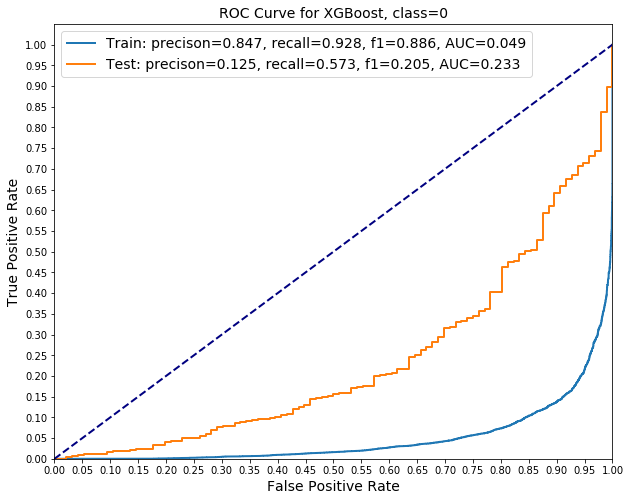

In [224]:
ROC_curve_train(xgb, 'XGBoost', 0)

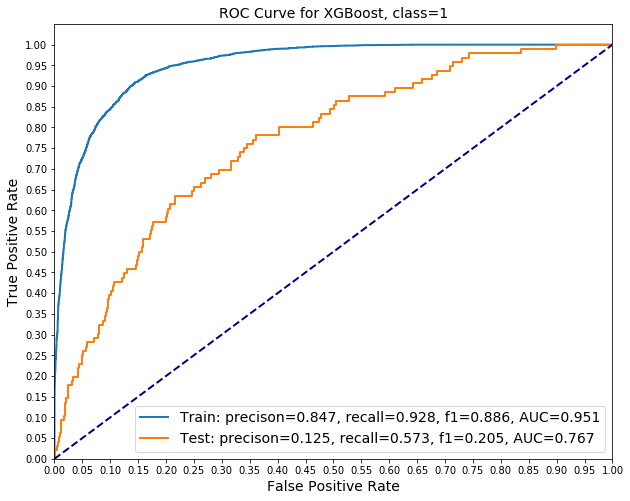

In [225]:
ROC_curve_train(xgb, 'XGBoost', 1)

**Comments**

* Overall, the baseline model performance is not very good. There is a huge overfitting.
* The model performance in identfying the non-bankruptcy companies (class 0) is good. 
* However, model fails to identify the bankruptcy companies (class 1).

### Data after Ouliers removed

At this point, it is not clear to me how significant outliers for the classification. 
Therefore, I would like to see the performance of the model after removing outliers.

In [188]:
df3_noOut = pd.read_csv('data/data3_noMiss_noOut.csv')

y_noOut = df3_noOut['class']
X_noOut = df3_noOut.drop('class', axis=1)

X_train_noOut, X_test_noOut, y_train_noOut, y_test_noOut = train_test_split(X_noOut, y_noOut, test_size=0.20, 
                                                                            random_state=42)

scaler_noOut = StandardScaler()
X_train_noOut = scaler_noOut.fit_transform(X_train_noOut)
X_test_noOut = scaler_noOut.transform(X_test_noOut)

smote_noOut = SMOTE()
X_train_rs_noOut, y_train_rs_noOut = smote_noOut.fit_resample(X_train_noOut, y_train_noOut)

In [189]:
xgb_noOut = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_noOut.fit(X_train_rs_noOut, y_train_rs_noOut)

print('Data3, resampled training, Outliers removed:\n')
print('Training Data:\n', classification_report(y_train_rs_noOut, xgb_noOut.predict(X_train_rs_noOut)))
print('Testing Data:\n', classification_report(y_test_noOut, xgb_noOut.predict(X_test_noOut)))

Data3, resampled training, Outliers removed:

Training Data:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      7627
           1       0.84      0.91      0.87      7627

    accuracy                           0.87     15254
   macro avg       0.87      0.87      0.87     15254
weighted avg       0.87      0.87      0.87     15254

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      1901
           1       0.15      0.61      0.24        98

    accuracy                           0.81      1999
   macro avg       0.56      0.71      0.56      1999
weighted avg       0.94      0.81      0.86      1999



**Comments**
* Removing outliers decreased the overfitting a bit.
* Increased the overall performance on testing data a little.
* I decided not to remove the outliers in my analysis. I will leave the model to handle the outliers.

## Parameter Tuning XGBoost

I will use GridSearchCV to determine the optimum parameters.

I will use scoring 'f1' for tuning.

In [192]:
# Tuning XGBClassifier with GridSearchCV

start=datetime.now()

xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [2, 3, 4, 5, 6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [30, 100],
}

xgb_gs = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='f1')
xgb_gs.fit(X_train_rs, y_train_rs)

print('Data 3, XGboost, Parameter Tuning Results:\n')
print("Best Parameter Combination:", xgb_gs.best_params_)
print('Training Data:\n', classification_report(y_train_rs, xgb_gs.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, xgb_gs.predict(X_test)))

end=datetime.now()

print('Process time:', end-start)

Data 3, XGboost, Parameter Tuning Results:

Best Parameter Combination: {'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7961
           1       1.00      1.00      1.00      7961

    accuracy                           1.00     15922
   macro avg       1.00      1.00      1.00     15922
weighted avg       1.00      1.00      1.00     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1993
           1       0.25      0.33      0.29        96

    accuracy                           0.92      2089
   macro avg       0.61      0.64      0.62      2089
weighted avg       0.93      0.92      0.93      2089

Process time: 0:28:50.349067


**Comments**
* Model performance is improved.
* The overfitting is very high. 